In [13]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


df=pd.read_csv('./data/051910.csv',index_col=0).reset_index(drop=True)
code_name=pd.read_csv('./data/code_name.csv')
train=df[['open','high','low','volume']]
target=df[['close']]

In [102]:
def preprocessing(data):
    
    scaler= MinMaxScaler(feature_range=(-1, 1))
    data=scaler.fit_transform(data)
    data=np.array(data)
    
    return data,scaler
    
def split_data(data):
    
    prop=len(data)//5
    val=data[:prop]
    test=data[prop+1:2*prop]
    train=data[2*prop:]
    
    return np.array(train),np.array(val),np.array(test)

def make_seq(data,window_size):
    seq_data=[]
    for i in range(data.shape[0]-window_size):
        L=data[i:i+window_size]
        seq_data.append(L)
    return seq_data

In [103]:
train_data_normalized,scaler_train = preprocessing(train.iloc[:-1])
target_data_normalized ,scaler_test= preprocessing(target.iloc[1:])

train_seq=make_seq(train_data_normalized,window_size=5)
target_seq=make_seq(target_data_normalized,window_size=5)

x_train,x_val,x_test=split_data(train_seq)
y_train,y_val,y_test=split_data(target_seq)

In [105]:
class stock_net(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        
        super(stock_net, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.h_o=nn.Linear(hidden_dim,1)
        
    def forward(self,x):
        
        x=self.lstm(x)
        x=self.h_o(x[0])
        
        return x

In [106]:
emb_dim=x_train.shape[2] # feature size

In [107]:
haha_net=stock_net(emb_dim,5)
criterion = nn.MSELoss()
# Optimizer를 생성합니다.
optimizer = optim.SGD(haha_net.parameters(), lr=0.01)

In [137]:
Loss=[]
for i in range(x_train.shape[0]):
    optimizer.zero_grad()
    output=haha_net(torch.FloatTensor(x_train[i]).view(-1,5,4))
    loss = criterion(output, torch.FloatTensor(y_train[i]))
    loss.backward()
    optimizer.step()  
    if i%100==0:
        Loss.append(loss.item())
        print(loss.item())

C:\Users\limaries30\.conda\envs\python3.6\lib\site-packages\torch\nn\modules\loss.py:443: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([1, 5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.1970571130514145
0.00036957551492378116
0.005986717529594898
0.00021220619964879006
0.000710847438313067
0.002851681550964713
0.0007139982772059739
0.0030405421275645494
0.00234616850502789
0.005613713525235653
0.00019028462702408433
0.0014991990756243467
0.0005373482126742601
0.0003728073788806796
0.00013068904809188098
0.0019770225044339895
0.00016736453108023852
0.0015549316303804517
0.0007560825324617326
0.0016163847176358104
0.00040721980622038245
0.0010818049777299166
0.006845505908131599
0.00458196084946394
0.0020834608003497124
0.0009247269481420517
0.0002820793888531625
0.00013590564776677638


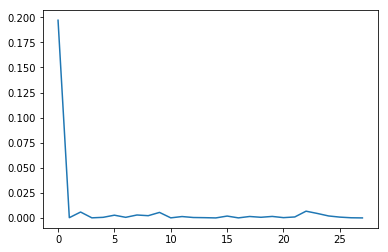

In [138]:
plt.plot(Loss)

In [133]:
Prediction=[]
for i in x_test:
    prediction=haha_net(torch.FloatTensor(i).view(-1,5,4))
    Prediction.append(prediction.view(-1).detach().numpy())

In [134]:
Prediction=np.array(Prediction).reshape(-1)

In [135]:
prediction=scaler_test.inverse_transform(Prediction.reshape(-1,1))
real=scaler_test.inverse_transform(y_test.reshape(-1,1))

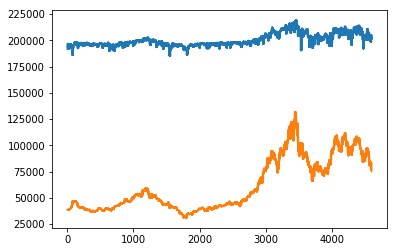

In [136]:
import matplotlib.pyplot as plt

plt.plot(prediction)
plt.plot(real)